# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

*conda env: ericsson-deep-research*

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [1]:
import os
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [ ]:
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents SDK** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [5]:
# from azure.ai.projects.models import BingGroundingTool

# bing_connection = project_client.connections.get(
#     connection_name=os.environ["BING_CONNECTION_NAME"]
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="BingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions="""
# You are a web search assistant. When provided with a search query, 
# use your web search tool (BingGroundingTool) to retrieve relevant results.

# ALWAYS FORMAT YOUR RESPONSE AS VALID JSON FOLLOWING THIS EXACT STRUCTURE:
# {
#     "subtopic": "the subtopic that was researched",
#     "query": "the actual search query you used",
#     "results": [
#         {
#             "title": "result title",
#             "full_text": "The complete content retrieved from the search result",
#             "url": "https://example.com/page",
#             "source": "name of the source (optional), if not available, use an empty string",
#             "published_date": "YYYY-MM-DD (optional), if not available, use an empty string"
#         }
#     ]
# }

# DO NOT include any text outside of this JSON structure.
# Ensure all JSON is properly formatted with quotes around keys and string values.
# For any optional fields that are unknown, use null instead of omitting the field.

# Include at least 3 relevant results for each search."""
# )

**OpenAI Agents**

In [6]:
from agents import (
    Agent,
    ModelSettings
)

planner_agent = Agent(
    name="PlannerAgent",
    instructions="""
    You are an expert research planner specializing in creating detailed research plans
    Your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """,
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=ModelSettings(
        max_tokens=16384,
        temperature=0.3,
    )
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. When given content from search results, "
        "create detailed, information-rich summaries that: \n"
        "1. Extract ALL important facts, statistics, findings, and insights relevant to the subtopic\n"
        "2. Preserve specific numbers, percentages, dates, and technical details whenever present\n"
        "3. Include industry-specific terminology and concepts that add depth to the research\n"
        "4. Maintain the source's key arguments and conclusions\n"
        "5. Provide thorough explanations rather than superficial overviews\n"
        "6. Each summary should be at least 150-250 words to ensure sufficient detail and context\n\n"
        "7. For technical content, preserve methodologies, technical specifications, and implementation details\n"
        "8. For comparative content, maintain all sides of the comparison with their specific attributes\n\n"
        
        "Remember that your summaries serve as the foundation for generating a comprehensive research report. "
        "The quality and depth of the final research report depends directly on how comprehensive your summaries are.\n\n"
        
        "FORMAT YOUR SUMMARY AS:\n"
        "KEY INSIGHTS: [2-3 bullet points of the most critical takeaways]\n\n"
        "[Detailed paragraph-form summary with maximum relevant information]"
    ),
    model=chatModel,
    output_type=str,
    model_settings=ModelSettings(
        max_tokens=16384,
        temperature=0.3,
    )
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with clear hierarchical organization (main sections, subsections, sub-subsections). "
        "Each major section should be rich in data, explanations, and narratives.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"
        
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, "
        "with minimal use of bullet points and maximum depth in paragraph form."
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=reasoningModel,
    output_type=ComprehensiveResearchReport
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=reasoningModel,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [7]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

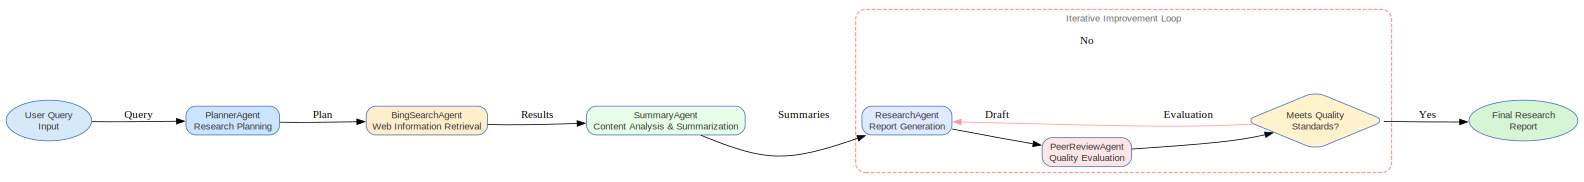

In [8]:
# How to use the module
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [9]:
user_query="What's the latest news in the field of AI? And how what big industries will be affected by it?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [10]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [11]:
from azure.ai.projects.models import MessageRole
from common.utils_search import parse_search_results
from tqdm import tqdm

search_results = []
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}
    
    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: "{query}"
        This is related to subtopic: "{subtopic.subtopic}"
        
        IMPORTANT: Your response must be a valid JSON object matching this structure:
        {{
            "subtopic": "{subtopic.subtopic}",
            "query": "{query}",
            "results": [
                {{
                    "title": "result title",
                    "full_text": "The complete content retrieved from the search result",
                    "url": "https://example.com/page",
                    "source": "name of the source (optional), if not available, use an empty string",
                    "published_date": "YYYY-MM-DD (optional), if not available, use an empty string"
                }}
            ]
        }}
        """
        
        # Create new thread for each query
        thread = project_client.agents.create_thread()
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role=MessageRole.USER,
            content=formatted_query,
        )

        # Process the run
        run = project_client.agents.create_and_process_run(
            thread_id=thread.id,
            agent_id=bing_search_agent.id
        )
        
        # Get the response text
        messages = project_client.agents.list_messages(thread_id=thread.id)
        if messages.get_last_text_message_by_role(role=MessageRole.agent).text.value:
            text_response = messages.get_last_text_message_by_role(role=MessageRole.agent).text.value
            
            # Parse the text response into structured data
            parsed_results = parse_search_results(text_response)
            
            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "results": parsed_results.results  # This will be a list of SearchResultItem objects
            })

        # Delete Thread when done
        project_client.agents.delete_thread(thread_id=thread.id)
    
    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [02:38<00:00, 31.76s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 15

Actually total search queries: 15



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [15]:
mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    task_summaries = []
    citations = []

    for query_result in subtopic_result["queries"]:
        for search_result_item in query_result["results"]:
            content_to_summarize = f"{search_result_item.title}: {search_result_item.full_text}"
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=f"Summarize the following content:\n{content_to_summarize}"
            )
            task_summaries.append(summary_response.final_output)
            
            citations.append(Citation(
                title=search_result_item.title,
                url=search_result_item.url
            ))

    mapped_chunks.append({
        "subtopic": subtopic_result["subtopic"],
        "summaries": task_summaries,
        "citations": [citation.model_dump() for citation in citations]
    })


Summarizing subtopics: 100%|██████████| 5/5 [02:47<00:00, 33.53s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [16]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report"
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [ ]:
from agents import HandoffCallItem

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [18]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Introduction

Artificial intelligence (AI) has experienced remarkable growth over the past decade, evolving from a niche field limited to research laboratories into a transformative technology reshaping entire industries. Recent years have seen significant breakthroughs in machine learning, natural language processing, computer vision, and generative AI models, sparking an unprecedented wave of commercial and consumer adoption. Across sectors like healthcare, finance, manufacturing, logistics, and media, AI is revolutionizing how products are developed, services are delivered, and strategic decisions are made. At the same time, these rapid advancements in AI raise new challenges, such as ethical considerations, workforce displacement, and regulatory concerns. Companies must now weigh powerful gains in efficiency and innovation against the importance of responsible AI practices to preserve quality, safety, and trust. In the following report, we offer a comprehensive analysis of the latest AI breakthroughs, examine AI’s growing influence on major industries, and explore the key issues, trade-offs, and future prospects that define this technological transformation. By synthesizing findings from diverse and credible sources, the report provides an authoritative resource for understanding how AI is reshaping modern business and society.

---

# 1. Recent Advancements in AI Technology

Over the last few years, AI has evolved at a breakneck pace, shifting from an emerging area of research to a central element of modern digital transformation. The year 2023 in particular proved to be a breakout moment for generative AI, wherein models such as ChatGPT and Bard demonstrated capabilities to produce text, answer questions, and engage in dialogue with striking fluency. As surveyed by multiple organizations, nearly one-quarter of executives worldwide have adopted generative AI tools in some capacity, often for content creation, ideation, or process automation. These personal experiences of leaders with AI reflect the transition of AI from a future-looking experiment to a mature, operational advantage in the marketplace. Moreover, board-level discussions among many enterprises increasingly focus on generative AI as a strategic priority, signaling significant momentum in corporate adoption of novel AI tools [1].

Another noteworthy milestone can be seen in how AI is reshaping drug discovery. Isomorphic Labs, for instance, is a clandestine startup originating from Google DeepMind, dedicated to harnessing AI’s predictive capabilities for expediting drug development. While the company remains tight-lipped about its internal processes, it stands at the forefront of advanced machine learning applications in life sciences, aiming to reduce the historically long periods and high costs that characterize drug trials [2]. These developments illuminate the broader shift toward AI-driven processes in scientific and industrial innovation.

Outside healthcare, AI is also revolutionizing foundational tasks in natural language processing, computer vision, and reinforcement learning. ChatGPT and Bard refine the art of conversational AI models, while models like Stable Diffusion 2.0 and AlphaFold push the boundaries in image generation and protein folding prediction, respectively. Stable Diffusion 2.0 allows for realistic, high-resolution image outputs based on textual prompts, making it invaluable in industries such as design, marketing, and entertainment. Meanwhile, AlphaFold has dramatically boosted the pace of research in molecular biology by predicting protein structures with high accuracy, opening transformative pathways in medical research and synthetic biology [3]. Combined, these recent innovations signal a hyper-acceleration of AI capability and a gradual but inevitable integration of AI models into mainstream industry workflows.

In hardware, Nvidia maintains a vanguard role in advancing AI chips optimized for deep learning and large-scale data processing. Announcements from Nvidia’s GTC 2025 conference highlight next-generation GPUs, including the Blackwell Ultra architecture, capable of delivering unprecedented computational power. Partnerships with auto manufacturers like General Motors showcase how computational breakthroughs support cutting-edge autonomous vehicle initiatives, while the broader industry anticipates that AI hardware improvements will reinforce expansion in machine learning, generative AI, and robotics [6]. At the same time, regulatory considerations are being actively debated at government levels, reflecting the growing acknowledgment that AI’s rapid growth needs measured oversight. Issues of ethics, data privacy, algorithmic bias, and transparency feature prominently in emerging frameworks, as policymakers strive to ensure that these AI revolutions produce equitable benefits and manageable risks for society [5].

AI developments now extend beyond standard business applications, bringing about fundamental changes in robotics, neuromorphic systems, and even attempts to decipher animal communications. Innovations like magnetoreceptive e-skin contribute to more immersive virtual reality experiences, while AI-supplemented robotics refine complex tasks from cooking to advanced manufacturing. In these areas, AI acts as a scalable, data-driven tool, forging net new fields of inquiry and synergy between technology and biology. It is thus clear that AI’s technical base—founded on leaps in deep learning, broader generative models, and specialized hardware—continues to expand, setting the stage for deep cross-disciplinary impacts.

---

# 2. Impact of AI on the Healthcare Industry

Few sectors exhibit as much promise and urgency for AI adoption as healthcare. Rapidly maturing data analytics and machine learning models address longtime challenges such as diagnostic accuracy, patient engagement, and cost burdens.

## 2.1 AI-Enhanced Diagnostics

Medical diagnostics occupy a critical place in healthcare, shaped by accuracy, timeliness, and scalability. AI systems capable of analyzing imaging scans—X-rays, MRIs, CT scans—and identifying anomalies with remarkable precision are already making strides. Deep learning algorithms can detect subtle patterns in medical images that might be missed by humans, thereby reducing diagnostic error rates for diseases like cancer or cardiovascular conditions. Some studies show that AI-assisted analysis can result in earlier detection and intervention, improving patient outcomes significantly [1][3]. Beyond imaging, AI is showing promise in genomics-based tests, facilitating personalized medicine by matching treatments and patient genetic profiles, thereby minimizing trial-and-error approaches.

## 2.2 Drug Discovery and Development

The high cost and multi-year timelines of drug discovery have long been a barrier to bringing novel treatments to patients. AI is revolutionizing this space via advanced computational models that quickly screen candidate molecules, simulate drug-target interactions, and predict toxicity. By reducing the number of dead-end compounds before clinical trials begin, AI systems lower research and development costs and shorten the path to market for new therapies. Isomorphic Labs, spun off from Google DeepMind, stands out as a prime example of AI’s role in pharmaceutical breakthroughs. Their close ties to cutting-edge machine learning research hint at an era when traditional drug discovery bottlenecks may be drastically reduced [2]. Meanwhile, generative AI methods allow modeling of candidate molecular structures in near-real time, accelerating identification of promising leads. These technologies carry broader potential for addressing a range of diseases that have historically proven elusive for conventional screening.

## 2.3 Personalizing Patient Care

AI’s ability to process massive data streams extends into telemedicine, remote patient monitoring, and personalized healthcare services. AI-driven virtual health assistants can track patient vitals, send reminders for medications, and even offer preliminary consultations. Predictive analytics gleaned from wearable sensors can anticipate health issues, such as potential spikes in blood pressure, allowing for timely preventive measures. Additionally, personalized medicine guided by AI is moving from concept to reality. Machine learning models parse patient medical histories, laboratory data, and social determinants of health to prescribe targeted treatment plans. This approach grants clinicians nuanced insights into patient risk profiles, enabling them to intervene early and improve patient outcomes [3][4].

## 2.4 Operational Efficiency and Cost Reduction

AI is also retooling hospital operations and administrative processes. High volumes of patient records, insurance claims, and regulatory filings make healthcare susceptible to inefficiency and errors. AI-enabled document management solutions automate data entry and compliance checks for insurance, thus reducing administrative overhead. Predictive analytics can forecast patient flow, align staffing, and manage inventory for critical supplies, thereby minimizing waste. Market analyses expect AI adoption in healthcare to grow at more than 30% annually through 2030, suggesting a robust trajectory for more integrated and cost-effective healthcare systems [1][3].

## 2.5 Ethical Considerations

While healthcare stands to benefit significantly from AI, concerns around patient privacy, algorithmic bias, and accountability require attention. Medical data is among the most sensitive of all information. Consequently, compliance with regulations such as HIPAA in the United States becomes more complex as AI systems interface with patient data. Bias in training datasets—if unaddressed—could produce skewed diagnostic or risk assessment outcomes, disproportionately affecting marginalized communities. A robust ethical framework and continuous validation of AI models in clinical settings are therefore essential. As healthcare organizations increase AI adoption, a collaborative interchange among clinicians, technologists, and ethicists must define best practices in data governance and accountability [4][7].

---

# 3. AI’s Influence on the Finance Sector

AI’s expansion in finance has been rooted in the technology’s capacity to handle massive data volumes, deliver predictive insights, and automate a wide range of transactions. Notably, the integration of machine learning into financial services is streamlining underwriting, risk assessment, trading, and corporate advisory.

## 3.1 Fraud Detection and Risk Management

Financial institutions face relentless threats from fraudulent schemes that exploit the complexities of modern digital payment systems. AI counters these threats by detecting anomalies and suspicious transaction patterns in real time. Distinct from traditional rule-based systems, AI can perform nuanced analyses of account behaviors across millions of events and identify even subtle signs of illicit activity. Similarly, in risk management, AI models analyze historical and real-time data to estimate credit risk, market movements, and liquidity vulnerabilities. This dynamic approach equips lenders and asset managers with early warnings about potential defaults or market downturns, making risk mitigation efforts more preemptive [1][4].

## 3.2 Generative AI and Automation in Banking

Growing adoption of generative AI can bring an estimated $200-340 billion in additional banking revenue annually, driven by automation of complex tasks, improved customer service, and more accurate analytics [2]. Chatbots backed by sophisticated language models serve as frontline support, handling account inquiries, guiding users through loan applications, or generating personalized financial advice. On the back end, banks use AI to automate labor-intensive tasks such as regulatory filings or compliance checks, drastically reducing person-hours. Moreover, advanced AI solutions help banks glean insights from unstructured documents—like legal texts or merger and acquisition dossiers—thus accelerating operational workflows.

## 3.3 AI in Investment Management

Systematic investing has benefited from AI and data analytics for over two decades, but recent growth in computational power and algorithm complexity has expanded the boundaries of what is possible. Investment managers now integrate AI-based sentiment analysis, pattern recognition, and risk modeling to improve portfolio returns and optimize asset allocation. Firms like BlackRock rely on AI-driven tools (e.g., Thematic Robot) to detect emergent themes across news and social data, swiftly translating these insights into thematic equity basket construction [7]. Furthermore, AI helps streamline data triage, accelerate discovery of new market opportunities, and facilitate real-time adaptation to market conditions. Surveys reveal that more than half of investment managers use, or plan to adopt, AI technologies in their core processes, underlining a broader acceptance of machine learning as an investment edge [8].

## 3.4 Ethical and Governance Considerations

Although AI is revolutionizing financial services, obstacles remain in the form of potential biases in credit scoring, data privacy, and operational risk. If training data used by AI models does not capture diversity, the results might inadvertently disadvantage certain groups, resulting in discriminatory lending practices. Regulators now look carefully at how AI influences consumer outcomes, prompting closer scrutiny of black-box models in finance. Moreover, as banks and investment houses deepen their reliance on AI for critical activities—from risk modeling to trading—internal governance frameworks must keep pace. Inadequate oversight could lead to poor risk controls or liability issues in the event of algorithmic failures. Hence, robust compliance protocols, along with interpretability of AI models, represent growing priorities for financial institutions [3].

---

# 4. Effects of AI on Manufacturing and Logistics

Another domain undergoing rapid AI-driven change is the manufacturing and logistics sector, where automation, predictive maintenance, and real-time analytics promise to drastically reduce inefficiencies in production lines and supply chains.

## 4.1 Smart Factories and Predictive Maintenance

The emergence of smart factories has solidified AI as a linchpin of modern manufacturing. These environments rely heavily on sensor-laden production lines, robot-assisted assembly, and software-driven oversight. Predictive maintenance is a hallmark example of AI’s impact. Rather than adhering to fixed maintenance schedules, factories harness AI models that continuously monitor equipment health, analyzing vibration, temperature, and performance data to predict possible breakdowns. Proactive repairs can then be performed to avoid sudden halts in production, thereby saving substantial time and capital. Early adopters report up to 20% cost reductions in converting raw materials into finished products, mostly attributed to workforce productivity gains powered by AI [2].

## 4.2 Quality Control and Generative Design

Manufacturers increasingly trust AI-based computer vision algorithms to perform quality checks on items moving along high-speed conveyor belts. Trained neural networks can detect minute defects or deviations that manual inspections might overlook, guaranteeing consistent product standards. Moreover, generative AI techniques now serve as a support system in inventing new product prototypes or optimizing existing designs. These design algorithms evaluate a wide range of parameters—such as materials, structural tolerances, and intended functionality—to iterate potential solutions. This iterative, data-driven approach reduces lead times and fosters creativity, with final prototypes then validated physically for feasibility.

## 4.3 AI-Driven Supply Chain Management

Beyond the factory floor, AI directs supply chain optimization, from route planning in transportation to dynamic inventory management. Enhanced logistics systems leverage predictive analytics to balance inventory levels, preventing overstock and stockouts. AI can integrate historical sales data with real-time shipping updates and external factors like weather or political events, ensuring the best possible alignment of supply and demand projections [4][5]. One of the notable challenges remains the high initial costs of deploying AI systems, such as specialized sensors, robotic installations, and safe integration within legacy software. Nonetheless, larger firms continue to push ahead, deploying collaborative robots for complex tasks and adopting real-time tracking technologies for end-to-end supply chain visibility.

## 4.4 Automation’s Impact on Labor and Sustainability

With AI-driven robotics and automation taking over repetitive tasks in factories or warehouses, the human labor force shifts toward supervisory, strategic, or emotionally intelligent roles that bots cannot fulfill easily. While these shifts promise improved safety and relief from physically demanding tasks, they also raise concerns about job displacement for workers who lack upskilling opportunities. In logistics, rising e-commerce volumes and labor shortages have accelerated the deployment of automated picking, packing, and sorting solutions, which can operate around the clock [7]. Industry analyses highlight that the net impact may well be positive if industries invest in reskilling and advanced capabilities, positioning employees to succeed in more cognitively demanding tasks. Moreover, AI stands out as a tool for forging more sustainable operations, using real-time data to reduce energy consumption, curtail carbon emissions, and minimize waste along the supply chain [8].

---

# 5. AI’s Role in the Entertainment and Media Industry

The entertainment ecosystem—comprising film, television, music, gaming, and digital media—reflects another major frontier for AI-led innovation. Technologies such as generative AI, automated editing, and AI-based personalization reshape both content creation and audience experiences.

## 5.1 AI-Assisted Content Creation

While human creativity remains central to artistic endeavors, AI now acts as a supportive partner in generating fresh ideas, scripts, and visual concepts. Tools like GPT-4 harness advanced language models to formulate initial drafts of stories or create marketing copy, which content creators can refine. Similarly, AI-powered editing software rapidly sorts through hours of raw footage to compile workable rough cuts, reducing the often laborious post-production stage. Highly sophisticated modules like Adobe Sensei further expedite tasks like image manipulation or effects creation, empowering creatives to experiment with near-instant visual transformations [4]. As AI streamlines these labor-intensive tasks, creators can spend more time experimenting and refining their craft, leading to an expanded range of final products.

## 5.2 Personalization in Media

In an age of abundant streaming services and content offerings, personalization is an essential competitive advantage. AI systems analyze user preferences—watch history, social media interactions, even biometric data—and match viewers to content they might find compelling. This approach transcends simplistic “recommended for you” algorithms, offering predictive insights that anticipate incremental user shifts in taste. Media providers thus rely on analytics to inform future content creation, ensuring that new offerings meet or exceed the expectations of niche audience segments. Audience engagement, dwell times, and loyalty can all rise as AI tailors content formats and delivery schedules [3].

## 5.3 Advancements in Visual Effects and Production Efficiencies

Directors such as James Cameron have voiced optimism about AI’s ability to elevate film-making rather than curtail creative expression. AI not only cuts production costs via automation but also introduces advanced visual processes in special effects and voice modulation. Techniques like deepfake-based de-aging or avatar replication underscore how AI can stretch the boundaries of cinematic visuals, enabling fresh narrative possibilities. Entire scenes can be quickly assessed for continuity or lighting anomalies, a function that used to rely heavily on time-consuming frame-by-frame evaluation by human editors. Meanwhile, media companies adopt machine learning to expedite subtitling, translations, and compliance checks, making global distribution more seamless [2][5].

## 5.4 Ethical and Authenticity Challenges

The entertainment sector grapples with issues of authenticity and ownership, particularly as generative AI can simulate recognizable voices or even replicate certain artistic styles. Actors and union representatives have expressed worries that sequels and spin-offs may use AI-generated characters, diminishing the need for real-life performers or voice-over artists. Similarly, as AI-generated scripts or music become more prevalent, there is apprehension over an oversaturated market of “content” that lacks genuine creative impulses from humans [6][8]. This environment fosters concerns about the intersection of IP rights and AI-driven creations, raising questions about credits for authorship and compensation if AI replicates an artist’s or writer’s distinct style. In response, entertainment professionals emphasize the critical role of balanced AI frameworks that protect creative talent while maintaining the flair and novelty that define the industry.

---

# 6. Data Visualization: An Impact Assessment Matrix Across Industries

Below is a simple matrix summarizing the principal areas impacted by AI across five major sectors and the extent to which AI solutions have advanced:

| Industry         | Primary AI Applications               | Maturity of AI Adoption  | Key Benefits                                 | Key Challenges                      |
|------------------|---------------------------------------|--------------------------|----------------------------------------------|--------------------------------------|
| Healthcare       | Diagnostics, Drug Discovery, Remote   | Medium to High           | Accurate diagnoses, shortened R&D timelines, | Data privacy, algorithmic bias       |
|                  | Monitoring                             |                          | operational efficiency                       |                                    |
| Finance          | Fraud Detection, Risk Analysis,       | Medium to High           | Reduced fraud, real-time decision-making,    | Regulatory compliance, model biases  |
|                  | Automated Trading                     |                          | better customer engagement                   |                                    |
| Manufacturing &  | Predictive Maintenance, Quality       | Medium                   | Reduced downtime, improved product quality,  | Implementation cost, workforce       |
| Logistics        | Control, Supply Chain Optimization    |                          | supply chain resilience                      | reskilling                         |
| Entertainment    | Script Generation, Visual Effects,    | Low to Medium            | Content personalization, cost savings,       | IP rights, authenticity, potential   |
| & Media          | Automated Editing                     |                          | enhanced visual innovation                   | job displacement                   |

(Adapted from multiple sources listed in the References section.)

---

# 7. Conclusion and Future Outlook

The rapid escalation of AI’s capabilities—from generative models that produce human-like text and images to specialized algorithms driving industrial automation—reveals a technology approaching maturity. While generative AI has largely defined AI’s public image through chatbots and creative tools, parallel advances in robotics, predictive analytics, and specialized hardware confirm that AI is reshaping every dimension of society. Across healthcare, finance, manufacturing, logistics, and entertainment, AI’s promise is clearest in its ability to automate repetitive tasks, unveil powerful insights from large datasets, and amplify outcomes at previously unattainable scales.

Nonetheless, every opportunity introduced by AI brings complementary challenges. The capacity of AI to accelerate operations in hospitals or warehouses may necessitate new training regimes and workforce realignments. AI-enabled personalization in finance or media provokes deeper ethical questions about data privacy and the potential for algorithmic biases. Meanwhile, sustainability emerges as a cross-industry theme, with AI used not only for operational efficiency but also for lowering carbon footprints.

Responsible AI frameworks will define how equitably these technologies are introduced, shaping public trust in the decades ahead. Regulatory regimes worldwide are beginning to draft guidelines to address issues of transparency, accountability, and bias. From a technical lens, interpretability of AI models—often labeled “explainable AI”—has become a focal point for bridging the knowledge gap between data scientists and policymakers.

As the pace of AI advancements marches forward, organizations must prioritize careful integration strategies, robust ethical protocols, and continuous skill development for employees. Successful businesses in the AI era are those that combine the powerful abilities of intelligent computing with intrinsic human ingenuity. Rather than replacing people, AI can act as a catalyst for innovation, enabling impactful progress across industries, from lifesaving treatments in healthcare to more immersive entertainment experiences. In these coming years, balancing technology adoption with robust governance will determine whether AI inaugurates a new golden age of innovation or exacerbates persistent societal issues. The potential for transformative change is within reach if the global community invests in ensuring AI truly serves the common good.

---

# References

[1] The state of AI in 2023: Generative AI’s breakout year, https://www.mckinsey.com

[2] Inside Isomorphic Labs, the secretive AI life sciences startup spun off from Google DeepMind, https://www.msn.com

[3] Latest Advances in Artificial Intelligence and Machine Learning, https://techlasi.com

[4] Artificial Intelligence News -- ScienceDaily, https://www.sciencedaily.com/news/artificial_intelligence/

[5] Latest Developments in Artificial Intelligence: March 2025 Update, https://bastakiss.com/latest-developments-in-artificial-intelligence-march-2025-update/

[6] Nvidia's GTC 2025 Highlights AI Hardware Innovations, https://www.nvidia.com/en-us/gtc/

[7] AI Action Plan Proposals and Cutting-Edge Platforms Unveiled at Nvidia GTC 2025, https://www.maxmaverick.se

[8] Nvidia GTC 2025: Innovations in AI and GPU Technology Unveiled, https://ubos.tech

[9] Nvidia Unveils the Future: Cutting-Edge AI and Quantum Computing Chips at GTC 2025, https://opentools.ai

[10] AI in Health Care: Applications, Benefits, and Examples, https://www.coursera.org/articles/ai-in-health-care-applications-benefits-and-examples

[11] 10 real-world examples of AI in healthcare, https://www.philips.com/a-w/about/news/archive/standard/news/articles/2022/10-real-world-examples-of-ai-in-healthcare.html

[12] AI in Healthcare: Transforming the Industry, https://www.forbes.com/sites/forbestechcouncil/2023/07/10/ai-in-healthcare-transforming-the-industry/

[13] How AI Is Transforming Healthcare: Diagnosis, Treatment, and Beyond, https://www.sciencenewstoday.org

[14] How AI Has Transformed Healthcare's Future, https://www.bbc.com

[15] How AI is transforming women’s healthcare and closing the gender gap, https://www.msn.com

[16] The future of pharmaceuticals: Artificial intelligence in drug development, https://www.sciencedirect.com

[17] Integrating artificial intelligence in drug discovery and early drug development, https://biomarkerres.biomedcentral.com

[18] Artificial Intelligence (AI) Applications in Drug Discovery and Drug Delivery, https://www.mdpi.com

[19] What is artificial intelligence (AI) in finance?, https://www.ibm.com/topics/ai-in-finance

[20] The future of AI in banking, https://www.mckinsey.com/industries/financial-services/our-insights/the-future-of-ai-in-banking

[21] AI in financial services: Opportunities and challenges, https://www.forbes.com/sites/forbestechcouncil/2023/11/15/ai-in-financial-services-opportunities-and-challenges/

[22] What Is AI In Banking?, https://www.ibm.com

[23] AI in Banking: Role, Benefits, Challenges, and Future Outlook, https://pwskills.com

[24] The Role of AI in Banking, https://example.com/ai-banking

[25] How AI is Transforming Investing, https://www.blackrock.com

[26] 7 Unexpected Ways AI Can Transform Your Investment Strategy, https://www.investopedia.com

[27] AI in Investment Management, https://www.forbes.com

[28] How is AI being used in Manufacturing, https://www.ibm.com

[29] The Rise of AI in Manufacturing: 2025 Trends, Tools & Real-World Impact, https://www.authentise.com

[30] AI in Manufacturing: Benefits and Challenges, https://www.manufacturing.net

[31] Artificial intelligence in supply chain management: A systematic review, https://www.sciencedirect.com

[32] What Is AI in Supply Chain? - IBM, https://www.ibm.com

[33] Artificial intelligence in supply chain management: Benefits and challenges, https://www.sciencedirect.com

[34] ROBOTICS IN LOGISTICS - DHL, https://www.dhl.com

[35] 5 Key Trends in Logistics Automation and Autonomous Robots, https://www.rtinsights.com

[36] Automation in logistics: Big opportunity, bigger uncertainty, https://www.mckinsey.com

[37] AI: The creative partner transforming content creation, https://www.tvbeurope.com

[38] The Positive Impact of AI on Hollywood According to James Cameron, https://www.groupe-crc.org

[39] How AI is Revolutionizing Media and Entertainment, https://www.example.com

[40] Media Production with AI: 7 Useful Aspects of Innovation, https://datasciencedojo.com/blog/media-production-with-ai/

[41] Artificial Intelligence Use in Media and Entertainment, https://www.statista.com/topics/ai-use-in-media-and-entertainment/

[42] How AI is Revolutionizing Media Production, https://example.com/ai-media-production

[43] Artificial Intelligence’s Impact On The Global Entertainment Economy, https://www.forbes.com

[44] 6 ways AI could disrupt the entertainment industry, https://www.weforum.org

[45] How AI is reshaping the entertainment industry, https://www.techradar.com


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [19]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To explore the latest developments in artificial intelligence and analyze its impact on major industries.",
  "aggregated_summaries": [
    {
      "subtopic": "Recent advancements in AI technology",
      "summaries": [
        "**KEY INSIGHTS:**  \n- Generative AI has transitioned from a niche technology to a central focus for business leaders in 2023.  \n- Approximately 25% of surveyed executives are personally using generative AI tools, reflecting its rapid adoption.  \n- Over 25% of companies leveraging AI have integrated generative AI discussions into their board agendas, signaling its strategic importance.  \n\n**Detailed Summary:**  \nIn 2023, generative AI has emerged as a transformative force, elevating artificial intelligence